In [4]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('paper')

In [9]:
Mp = 1.e-8
def makesim(e=0.01, dtOverT = 0.01):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=Mp, P=1., e=e)
    #sim.add(m=Mp, P=2.4, e=0.1)
    sim.move_to_com()
    sim.dt = dtOverT*sim.particles[1].P

    return sim

In [22]:
alpha = (7./40.)**0.5
beta = 1/48./alpha

def X(sim, kepler, damp, a, b):
    kepler.step(sim, -a*sim.dt)
    damp.step(sim, b*sim.dt)
    kepler.step(sim, a*sim.dt)
    return sim

def Z(sim, kepler, damp, a, b):
    sim = X(sim, kepler, damp, -a, -b)
    sim = X(sim, kepler, damp, a, b)
    return sim

def corrector3(sim, kepler, damp):
    a1 = -alpha
    a2 = alpha
    b2 = beta/2.
    b1 = -beta/2.
    
    sim = Z(sim, kepler, damp, a2, b2)
    sim = Z(sim, kepler, damp, a1, b1)
    return sim 

def corrector3inv(sim, kepler, damp):
    a1 = -alpha
    a2 = alpha
    b2 = beta/2.
    b1 = -beta/2.
    
    sim = Z(sim, kepler, damp, a1, -b1)
    sim = Z(sim, kepler, damp, a2, -b2)
    return sim

def run(e=0.1, dt = 0.01, taua = 1000, tmax = 1000., corrector=0):
    simKD = makesim(e=e, dtOverT=dt)
    rebxKD = reboundx.Extras(simKD)
    modKD = rebxKD.load_force("modify_orbits_forces")
    rebxKD.add_force(modKD)
    psKD = simKD.particles
    psKD[1].params['tau_a'] = -taua

    simKD.integrator = "none"
    keplerKD = rebxKD.load_operator("kepler")
    integforceKD = rebxKD.load_operator("integrate_force")
    integforceKD.params['force'] = modKD
    integforceKD.params['integrator'] = reboundx.integrators["rk4"]

    rebxKD.add_operator(keplerKD, dt_fraction=1., timing="post")
    rebxKD.add_operator(integforceKD, dt_fraction=1., timing="post")

    sim = makesim(e=e, dtOverT=dt)
    sim.integrator = "ias15"
    rebx = reboundx.Extras(sim)
    mod = rebx.load_force("modify_orbits_forces")
    rebx.add_force(mod)

    ps = sim.particles
    ps[1].params['tau_a'] = -taua

    if corrector == 1:
        keplerKD.step(simKD, simKD.dt/2.)
        simKD.integrate(tmax, exact_finish_time=0)
        keplerKD.step(simKD, -simKD.dt/2.)
    elif corrector == 3:
        simKD = corrector3(simKD, keplerKD, integforceKD)
        keplerKD.step(simKD, simKD.dt/2.)
        simKD.integrate(tmax, exact_finish_time=0)
        keplerKD.step(simKD, -simKD.dt/2.)
        simKD = corrector3inv(simKD, keplerKD, integforceKD)
    else:   
        simKD.integrate(tmax, exact_finish_time=0)
    sim.integrate(simKD.t)
    return np.abs((simKD.calculate_energy()-sim.calculate_energy())/sim.calculate_energy()), sim.particles[1].P

In [23]:
%%time

e=0.1
taua = 10
tmax = 3*taua # initial orbital periods, more since period will decrease
Nout = 10
dts = np.logspace(-1.5, -5, Nout)
Eerrs, Eerrscorr1, Eerrscorr3 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
for i, dt in enumerate(dts):
    Eerrs[i], Pf = run(taua=taua, tmax=tmax, e=e, dt=dt)
    Eerrscorr1[i], Pf = run(taua=taua, tmax=tmax, e=e, dt=dt, corrector=1)
    Eerrscorr3[i], Pf = run(taua=taua, tmax=tmax, e=e, dt=dt, corrector=3)

/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:530: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


CPU times: user 24.9 s, sys: 9.75 ms, total: 24.9 s
Wall time: 24.9 s


In [24]:
Pf

0.011111434828422856

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


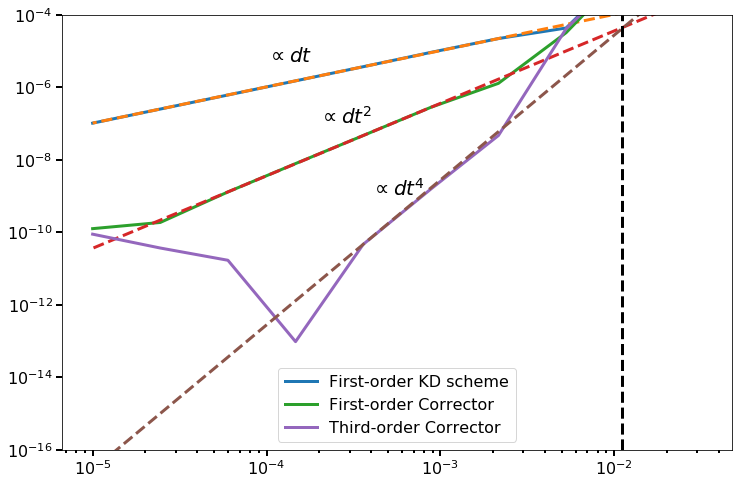

In [38]:
fig, ax = plt.subplots(figsize=(12,8))

mid = int(Nout/2)
ax.plot(dts, Eerrs, label='First-order KD scheme')
ax.plot(dts, Eerrs[mid]*dts/dts[mid], '--')
ax.plot(dts, Eerrscorr1, label='First-order Corrector')
ax.plot(dts, Eerrscorr1[mid]*(dts/dts[mid])**2, '--')
ax.plot(dts, Eerrscorr3, label='Third-order Corrector')
ax.plot(dts, Eerrscorr3[mid]*(dts/dts[mid])**4, '--')
ax.text(1.e-4, 5.e-6, r'$\propto dt$', fontsize=20)
ax.text(2.e-4, 1.e-7, r'$\propto dt^2$', fontsize=20)
ax.text(4.e-4, 1.e-9, r'$\propto dt^4$', fontsize=20)
ax.axvline(Pf, c='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1.e-16, 1.e-4])
ax.legend()
fig.savefig('dampingcorrectors.pdf', bbox_inches='tight')

# Implement higher order correctors, test with multiple planets (3 operator correctors?)

In [12]:
run(taua=10., tmax=10.)

0.00011019073645092657

In [22]:
run(taua=10., tmax=10., dtOverT=1.e-5, corrector=True)

2.315993145811363e-11

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


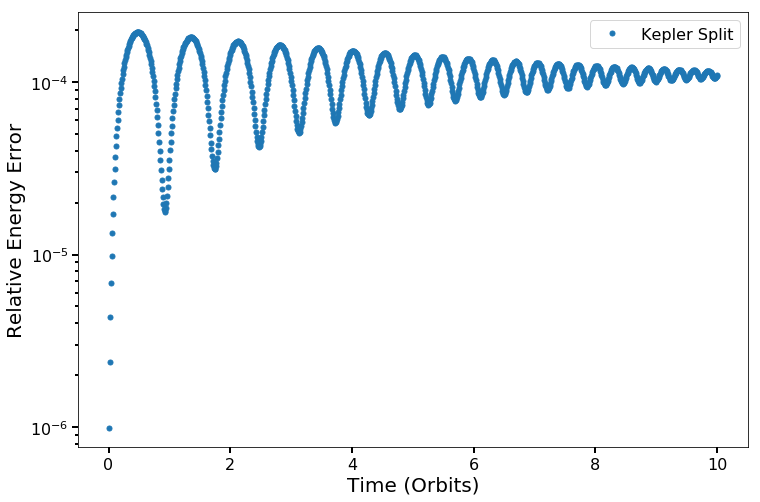

In [4]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((EsKD-Es)/Es), '.', label='Kepler Split')
#ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

In [3]:
Nout = 1000
e=0.1
dtOverT = 0.01
tmax = 10.
taua = tmax*1
times = np.linspace(0, tmax, Nout)

simKD = makesim(e=e, dtOverT=dtOverT)
rebxKD = reboundx.Extras(simKD)
modKD = rebxKD.load_force("modify_orbits_forces")
rebxKD.add_force(modKD)
psKD = simKD.particles
psKD[1].params['tau_a'] = -taua

simKD.integrator = "none"
keplerKD = rebxKD.load_operator("kepler")
integforceKD = rebxKD.load_operator("integrate_force")
integforceKD.params['force'] = modKD
integforceKD.params['integrator'] = reboundx.integrators["rk4"]

rebxKD.add_operator(keplerKD, dt_fraction=1., timing="post")
rebxKD.add_operator(integforceKD, dt_fraction=1., timing="post")

sim = makesim(e=e, dtOverT=dtOverT)
sim.integrator = "ias15"
rebx = reboundx.Extras(sim)
mod = rebx.load_force("modify_orbits_forces")
rebx.add_force(mod)

ps = sim.particles
ps[1].params['tau_a'] = -taua

EsKD, EsMDE, Es = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
fKD, fMDE, f = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
P = np.zeros(Nout)
dEs, cumdEs = np.zeros(Nout), np.zeros(Nout)
E0 = simKD.calculate_energy()

for i, time in enumerate(times):
    keplerKD.step(simKD, simKD.dt/2.)
    simKD.integrate(time, exact_finish_time=0)
    keplerKD.step(simKD, -simKD.dt/2.)
    sim.integrate(simKD.t)
    Es[i] = sim.calculate_energy()
    EsKD[i] = simKD.calculate_energy()
    fKD[i] = simKD.particles[1].f
    f[i] = sim.particles[1].f
    P[i] = sim.particles[1].P

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


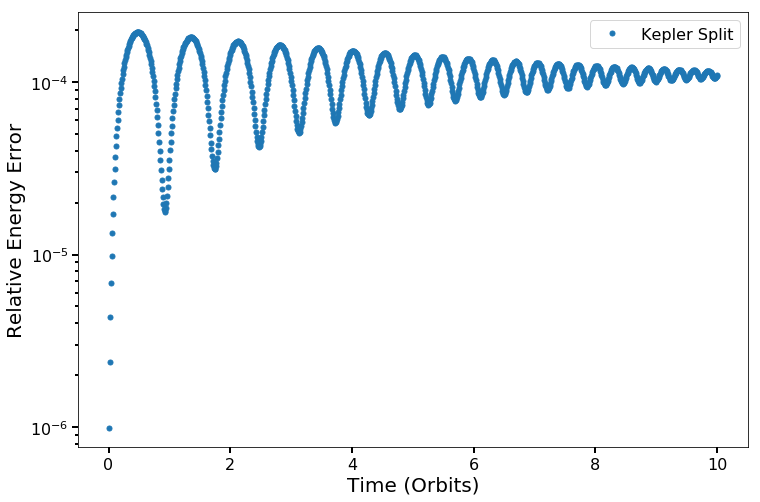

In [4]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((EsKD-Es)/Es), '.', label='Kepler Split')
#ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


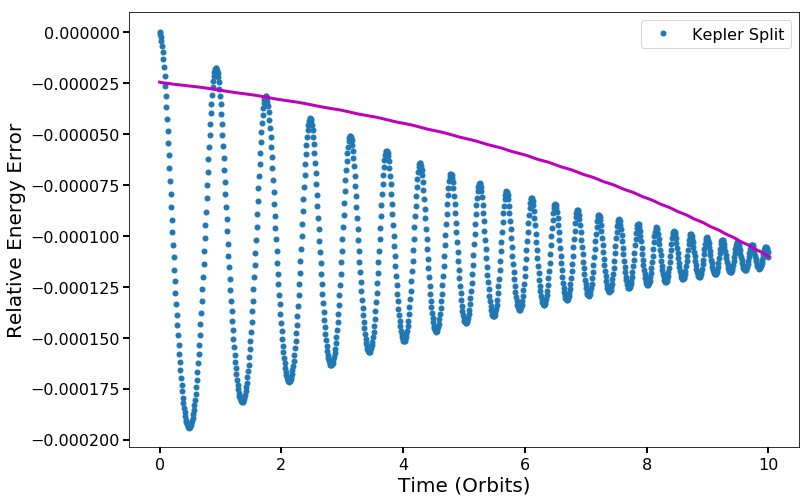

In [138]:
signedEerr = (EsKD-Es)/np.abs(Es)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, signedEerr, '.', label='Kepler Split')
ax.plot(times, signedEerr[-1]*P[-1]/P, 'm')
#ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

#ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([-1e-5, -1e-3])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


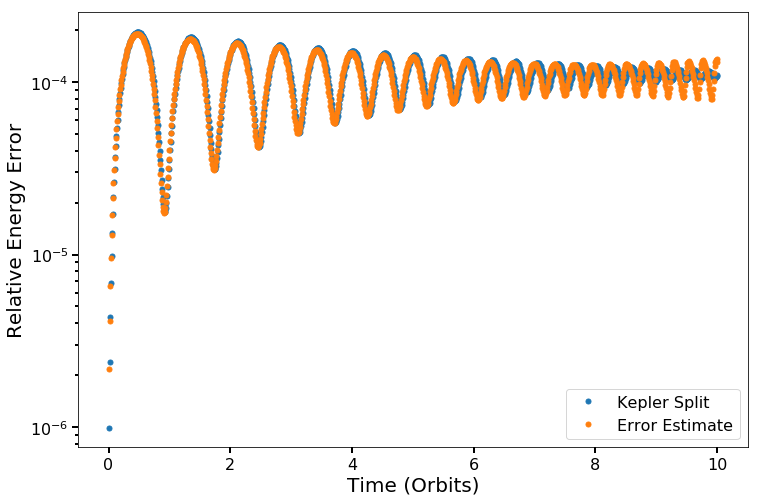

In [139]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((EsKD-Es)/Es), '.', label='Kepler Split')
ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

No handles with labels found to put in legend.


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


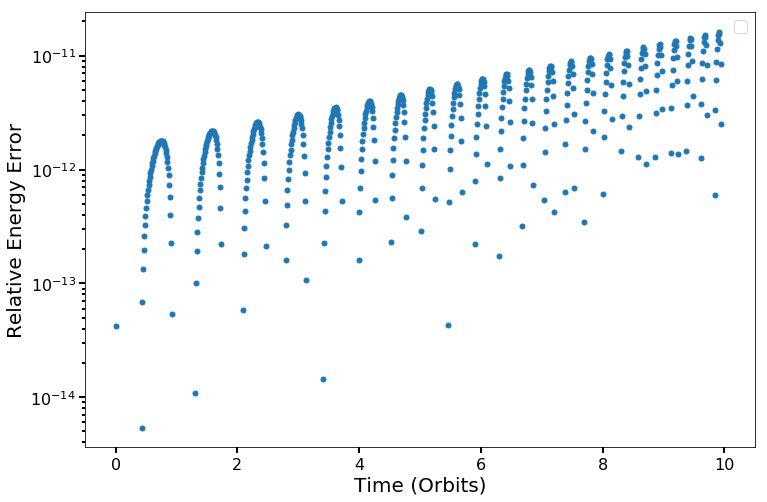

In [97]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, dEs, '.')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

No handles with labels found to put in legend.


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


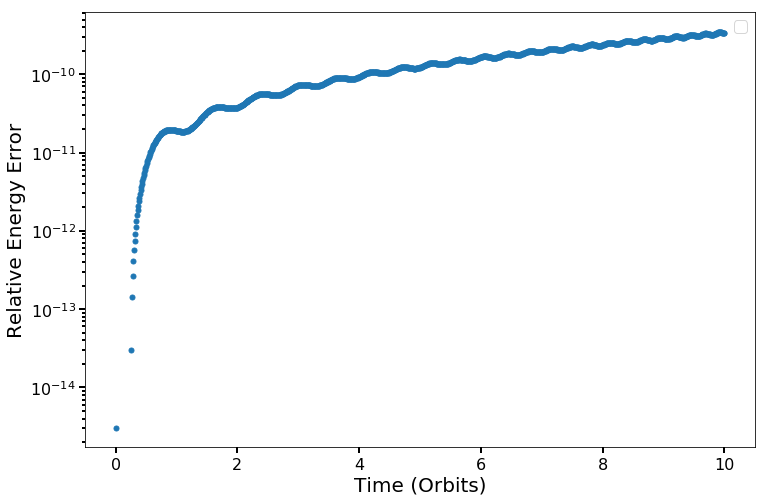

In [50]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, cumdEs, '.')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

When we do KD, we are effectively doing a [K,D] post timestep after IAS15, so we damp first for a positive timestep, and undamp later. This means that the first time we damp -v/tau, v is higher and so we damp more, but the second time we go to undo it with +v/tau, v is lower, so we don't make it all back. This would only be true with Euler, not if we integrate across timestep.

Also, we need to keep a fixed timestep for a splitting scheme to make any sense (since the ODEs it's solving depend on the timestep). If we integrate a damping system too long, then as the dynamical timescale approaches 10x the timestep or shorter (as say a planet migrates inward) then BCH no longer converges and you get lots of timestep resonances

Error at 0 ecc is second order in epsilon. I think at ecc > epsilon, error comes from change in a giving you a phase error, and fact that you're on an eccentric orbit mattering where you are along orbit. Phase doesn't matter to energy error.